In [3]:
import networkx as nx
import random
import EoN 
import matplotlib.pyplot as plt 
import pandas as pd
import statistics
import numpy as np
import copy 


In [24]:
#plot the fraction of infected nodes respect to gama=betha/mu
#for 5 network original network/ 30 % missing links in west/30% missing links in entire/
#30 % missing nodes in west/ 30 % missing nodes in entire
G_original=nx.read_gpickle("real_network/G_O_6_month.gpickle")
G_un_w_50=nx.read_gpickle("real_network/G_unw_entire_50.gpickle")
G_miss_30_w=nx.read_gpickle("real_network/G_miss_w_30.gpickle")
G_miss_30=nx.read_gpickle("real_network/G_miss_entire_30.gpickle")
#G_MN_30_w=nx.read_gpickle("test.gpickle")
#G_MN_30=nx.read_gpickle("test.gpickle")




In [387]:
def epi_SIK_Model_forThreshold(Graph,initial_infecteds,beta,mu):
    G=copy.deepcopy(Graph)
    infected = initial_infecteds.copy()
    killed=[]
    N=G.order()
    i=6 #number of steps of iteration
    susceptible = list(G.nodes())
    
    for infected_node in infected:
        if infected_node in susceptible: 
            susceptible.remove(infected_node)
    
    num_infected_results=[]
    num_killed=[]
    killed=[]
    num_killed.append(0)
    num_infected_results.append(float(len(infected)/N))
    #Inicializar el tiempo
    j=1
    while j<i:
        infected_1 = list()
        #Realizar la infección
        for node in infected:
            if len(set(G.neighbors(node)))>0:
                '''strategy here is that every time the first chance is get to the highest weight of edges in node neighbors. 
                if rhe neighbor with highest weight does not infect then the second chance is based on random sample choice'''
                edges = list(G.edges(node, data=True))
                if len(edges)==1:
                    neigh=edges[0][1]
                    if neigh in susceptible:
                    #neigh=set(G.neighbors(node))
                   # if neigh not in killed:
                    #    if neigh not in infected:
                     #       if  neigh not in list(infected_1):
                        if random.random()<1-((1-beta)**G[node][neigh]['weight']):
                            infected_1.append(neigh)
                            susceptible.remove(neigh)
                                    
                # if len(edges) > 0: #some nodes have zero edges going into it #this one could be useful in directed network
                else:
                    for nbr in set(G.neighbors(node)):
                        if nbr in susceptible:
                            #if neigh not in killed:
                            #if neigh not in infected:
                             #   if  nbr not in list(infected_1):
                            if random.random()<1-((1-beta)**G[node][nbr]['weight']):
                                infected_1.append(nbr)
                                susceptible.remove(nbr)
                                    
            #recover process
            if random.random()<mu:
                killed.append(node)
                
                    
                    
                    
        #Remover a los infectados de los susceptibles:
        infected += infected_1
        for node in killed:
            if node in infected: 
                infected.remove(node)
            
        for infected_node in infected:
            if infected_node in susceptible: 
                susceptible.remove(infected_node)
            
            

        #Registrar el porcentaje de nodos infectados en una lista para luego graficar
        num_infected_results.append(float(len(infected)/N))
        num_killed.append(float(len(killed)/N))
        #Actualizar el tiempo
        j += 1
                          
    return num_infected_results, num_killed
                          

def make_node_region_list(Graph,region):
    G=copy.deepcopy(Graph)
    region=str(region)
    list_node_region=[node for node,info in G.nodes(data=True) if info['region']==region]
    return list_node_region                            
                          
#function for make a list of fraction of infected cases respect to gama
def infected_fraction_gamma(Graph, initial_infecteds, mu):
     
    '''gama=np.arange(0, 1, 0.02).tolist()
    beta_range=[i * mu for i in gama]
    totall_number_of_nodes=Graph.order()'''  # اگه اینجوری بنویسیم با افزایش میو بتا افزایش پیدا میکنه در ضورتی که باید برعکس یاشه دلیاشم اینه که باید بتا و میو رو فیکس کنیم ازش گاما بدست بیاریم نه اینکه گاما فیکس باشه
    
    #to wee the epidemic threshold we just need the epidemic behaviour of network in small gamma
    #so the beta range does not need to go to 1
    #select a small range unless your program will take a long time
    beta_range=np.arange(0.01, 0.21, 0.01).tolist() #beta=0 alredy is in the I list because we have (0, len(initial_infected))
    #gamma_range=np.arange(0.05, 0.25, 0.05).tolist()
    totall_number_of_nodes=Graph.order()
    
#run epi_SIK for a range of beta on the network(original and missing link)
    infected_cases_gamma=[]
    infected_cases_gamma.append(float(len(initial_infecteds)/totall_number_of_nodes))

#infection process
    for b in beta_range:
        #b=round(g*mu,3)
        IN_list, Killed_list=epi_SIK_Model_forThreshold(Graph, initial_infecteds, b , mu)
        infected_cases_gamma.append(IN_list[-1])
        
    return infected_cases_gamma

def epidemic_threshold_multirun(beta_range, graph,IN_list, mu):
    dfs_ep=pd.DataFrame(beta_range, columns=['beta'])
    for i in range(1,3):
        #time.sleep(5)
        df_ep=infected_fraction_gamma(graph,IN_list,mu)
        dfs_ep.insert(i, f"vals_{i}", df_ep) 
    df_ep_all= dfs_ep.set_index('beta')
    mean_val_ep = df_ep_all.iloc[:,0:].mean(axis=1)
    std_val_ep= df_ep_all.iloc[:,0:].std(axis=1)
    min_val_ep = mean_val_ep - 2*std_val_ep
    max_val_ep = mean_val_ep + 2*std_val_ep
    df_ep_all.reset_index(inplace = True)
    return df_ep_all, mean_val_ep

In [149]:
#set initial infected list constant rate for network
#be carefull for the missing nodes scenario we need more inital infected nodes to have the same fraction
#of initial infected node with missing links scenario unless we do not count miising nodes as the original
#node of the networks. onther mthods: we should make fraction of initial infectd nodes(which are from missing nodes+
#some original nodes) to the total number of node(missing nodes + original nodes)

#initial infected nodes list for original and missing links network
IN_IN_risk_region=random.sample(make_node_region_list(G_original,'East'),10)+random.sample(make_node_region_list(G_original,'West'),10)

mu=0.1
I_o=infected_fraction_gamma(G_original,IN_IN_risk_region,mu)
#I_Mlink_30_w=infected_fraction_gamma(G_miss_30_w,IN_IN_risk_region,mu)
#I_Mlink_30=infected_fraction_gamma(G_miss_30,IN_IN_risk_region,mu)

mu1=0.4
I_o1=infected_fraction_gamma(G_original,IN_IN_risk_region,mu1)
#I_Mlink_30_w1=infected_fraction_gamma(G_miss_30_w,IN_IN_risk_region,mu1)
#I_Mlink_301=infected_fraction_gamma(G_miss_30,IN_IN_risk_region,mu1)

mu3=0.8
I_o3=infected_fraction_gamma(G_original,IN_IN_risk_region,mu3)

In [40]:
IN_IN_risk_region=random.sample(make_node_region_list(G_original,'East'),1)+random.sample(make_node_region_list(G_original,'West'),1)

In [317]:
#read the results
import pickle
with open ('real_network/Epidemic_Threshold/I_o_0.8', 'rb') as fp:
    I_o3=pickle.load(fp)
with open ('real_network/Epidemic_Threshold/I_misslink_0.8', 'rb') as fp:
    I_Mlink_303=pickle.load(fp)
with open ('real_network/Epidemic_Threshold/I_o_0.1', 'rb') as fp:
    I_o=pickle.load(fp)
with open ('real_network/Epidemic_Threshold/I_misslink_0.1', 'rb') as fp:
    I_Mlink_30=pickle.load(fp)
with open ('real_network/Epidemic_Threshold/I_o_0.4', 'rb') as fp:
    I_o1=pickle.load(fp)
with open ('real_network/Epidemic_Threshold/I_misslink_0.4', 'rb') as fp:
    I_Mlink_301=pickle.load(fp)

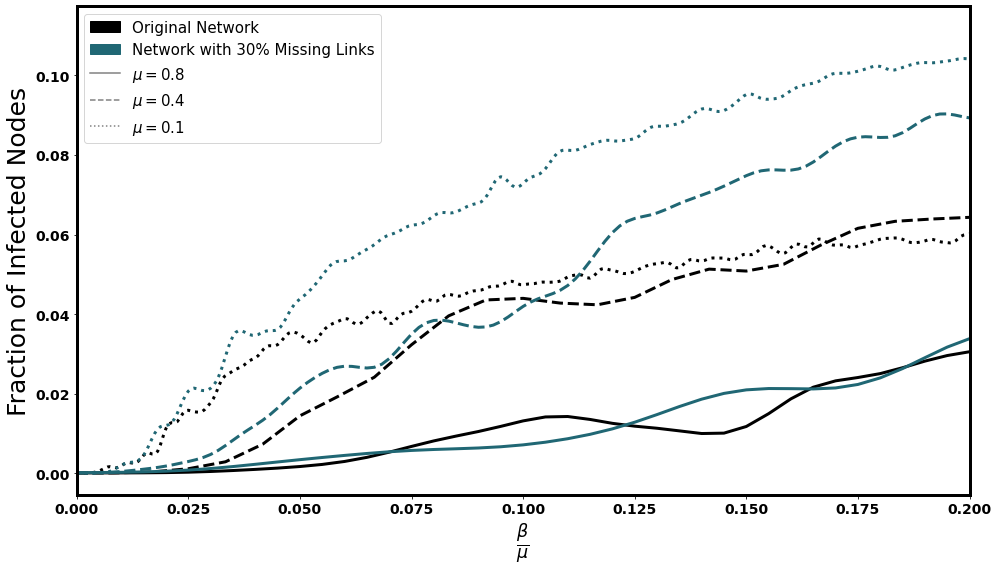

In [152]:
#when we plot I_o s the lines are very zigzag. So I smpoothed the plot
from scipy.interpolate import spline, make_interp_spline, BSpline
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter1d
x=np.array([i[0] for i in I_o])
y=np.array([i[1] for i in I_o])
x1=np.array([i[0] for i in I_o1])
y1=np.array([i[1] for i in I_o1])
x2=np.array([i[0] for i in I_o3])
y2=np.array([i[1]for i in I_o3])


y_new=gaussian_filter1d(y,sigma=2)
y1_new=gaussian_filter1d(y1,sigma=1)
y2_new=gaussian_filter1d(y2,sigma=2)


x_miss=np.array([i[0] for i in I_Mlink_30])
y_miss=np.array([i[1] for i in I_Mlink_30])
x1_miss=np.array([i[0] for i in I_Mlink_301])
y1_miss=np.array([i[1] for i in I_Mlink_301])
x2_miss=np.array([i[0] for i in I_Mlink_303])
y2_miss=np.array([i[1]for i in I_Mlink_303])

y_miss_new=gaussian_filter1d(y_miss,sigma=3)
y1_miss_new=gaussian_filter1d(y1_miss,sigma=3)
y2_miss_new=gaussian_filter1d(y2_miss,sigma=3)

fig, ax = plt.subplots(1,1,figsize=(16,9))

plt.plot(x,y_new,c='black',linewidth=3.0)
plt.plot(x1,y1_new,c='black',linestyle='--',linewidth=3.0)
plt.plot(x2,y2_new,c='black',linestyle='dotted',linewidth=3.0)

plt.plot(x_miss,y_miss_new,c='#206774',linewidth=3.0)
plt.plot(x1_miss,y1_miss_new,c='#206774',linestyle='--',linewidth=3.0)
plt.plot(x2_miss,y2_miss_new,c='#206774',linestyle='dotted',linewidth=3.0)
#ax.annotate('', (0.025, 0), xytext=(0.025+0.05, 0+0.02), 
 #   arrowprops=dict(facecolor='red', shrink=1))
fontsize = 14

for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
    tick.label1.set_fontweight('bold')
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
    tick.label1.set_fontweight('bold')
plt.rc('axes', linewidth=3) 
plt.xlabel(r'$\frac{\beta}{\mu}$',fontsize=25)
plt.ylabel('Fraction of Infected Nodes',fontsize=25)
plt.xlim(0,0.2)

import matplotlib.patches as mpatches
import matplotlib.lines as mlines
c1=mpatches.Patch(color='black', label='Original Network')
c2=mpatches.Patch(color='#206774', label='Network with 30% Missing Links')
c3= mlines.Line2D([], [], color='gray',linestyle='-', label=r'$\mu=0.8$')
c4= mlines.Line2D([], [], color='gray',linestyle='--', label=r'$\mu=0.4$')
c5 = mlines.Line2D([], [], color='gray', linestyle='dotted', label=r'$\mu=0.1$')
plt.legend(handles=[c1,c2,c3,c4,c5],fontsize=15)
plt.savefig('epidemic_threshold.pdf')

In [ ]:
beta_range1=np.arange(0, 0.21, 0.01).tolist()
mu1=0.4
df_miss_30_1, mean_miss30_1=epidemic_threshold_multirun(beta_range1,G_miss_30,IN_IN_risk_region,mu1)
df_1, mean_1=epidemic_threshold_multirun(beta_range1,G_original,IN_IN_risk_region,mu1)
mu3=0.8
df_miss_30_3, mean_miss30_3=epidemic_threshold_multirun(beta_range1,G_miss_30,IN_IN_risk_region,mu3)
df_3, mean_3=epidemic_threshold_multirun(beta_range1,G_original,IN_IN_risk_region,mu3)
mu=0.1
df_miss_30, mean_miss30=epidemic_threshold_multirun(beta_range1,G_miss_30,IN_IN_risk_region,mu)
df, mean=epidemic_threshold_multirun(beta_range1,G_original,IN_IN_risk_region,mu)

In [388]:
mu=0.1
df_miss_30, mean_miss30=epidemic_threshold_multirun(beta_range1,G_miss_30,IN_IN_risk_region,mu)

In [384]:
import pickle
with open ('real_network/Epidemic_Threshold/mean_o_5step_0.8', 'wb') as fp:
    pickle.dump(mean_3, fp)
with open ('real_network/Epidemic_Threshold/mean_o_5step_0.1', 'wb') as fp:
    pickle.dump(mean, fp)
with open ('real_network/Epidemic_Threshold/mean_o_5step_0.4', 'wb') as fp:
    pickle.dump(mean_1, fp)

In [376]:
beta_range=np.arange(0, 0.21, 0.01).tolist()
mu1=0.4
df_miss_30_w_1, mean_miss30_w_1=epidemic_threshold_multirun(beta_range,G_miss_30_w,IN_IN_risk_region,mu1)
#df_1, mean_1=epidemic_threshold_multirun(beta_range,G_original,IN_IN_risk_region,mu1)
mu3=0.8
df_miss_30_w_3, mean_miss30_w_3=epidemic_threshold_multirun(beta_range,G_miss_30_w,IN_IN_risk_region,mu3)
#df_3, mean_3=epidemic_threshold_multirun(beta_range,G_original,IN_IN_risk_region,mu3)
mu=0.1
df_miss_30_w, mean_miss30_w=epidemic_threshold_multirun(beta_range,G_miss_30_w,IN_IN_risk_region,mu)
#df, mean=epidemic_threshold_multirun(beta_range,G_original,IN_IN_risk_region,mu)G_miss_30_w

In [348]:
import pickle
with open ('real_network/Epidemic_Threshold/mean_miss_5tep_0.8', 'wb') as fp:
    pickle.dump(mean_miss30_3, fp)
with open ('real_network/Epidemic_Threshold/I_o_5step_0.8', 'wb') as fp:
    pickle.dump(mean_3, fp)
with open ('real_network/Epidemic_Threshold/mean_miss_5tep_0.4', 'wb') as fp:
    pickle.dump(mean_miss30_1, fp)
with open ('real_network/Epidemic_Threshold/I_o_5step_0.4', 'wb') as fp:
    pickle.dump(mean_1, fp)
    
with open ('real_network/Epidemic_Threshold/mean_miss_w_5tep_0.8', 'wb') as fp:
    pickle.dump(mean_miss30_w_3, fp)
with open ('real_network/Epidemic_Threshold/mean_miss_w_5tep_0.1', 'wb') as fp:
    pickle.dump(mean_miss30_w, fp)
with open ('real_network/Epidemic_Threshold/mean_miss_w_5tep_0.4', 'wb') as fp:
    pickle.dump(mean_miss30_w_1, fp)
    
with open ('real_network/Epidemic_Threshold/mean_unw_5tep_0.8', 'wb') as fp:
    pickle.dump(mean_unw50_3, fp) 
with open ('real_network/Epidemic_Threshold/mean_unw_5tep_0.1', 'wb') as fp:
    pickle.dump(mean_unw50, fp)
with open ('real_network/Epidemic_Threshold/mean_unw_5tep_0.4', 'wb') as fp:
    pickle.dump(mean_unw50_1, fp)    
    
with open ('real_network/Epidemic_Threshold/mean_unw_w_5tep_0.8', 'wb') as fp:
    pickle.dump(mean_unw50_w_3, fp)
with open ('real_network/Epidemic_Threshold/mean_unw_w_5tep_0.1', 'wb') as fp:
    pickle.dump(mean_unw50_w, fp)
with open ('real_network/Epidemic_Threshold/mean_unw_w_5tep_0.4', 'wb') as fp:
    pickle.dump(mean_unw50_w_1, fp)
      

In [390]:
with open ('real_network/Epidemic_Threshold/mean_miss_5tep_0.1', 'wb') as fp:
    pickle.dump(mean_miss30, fp)

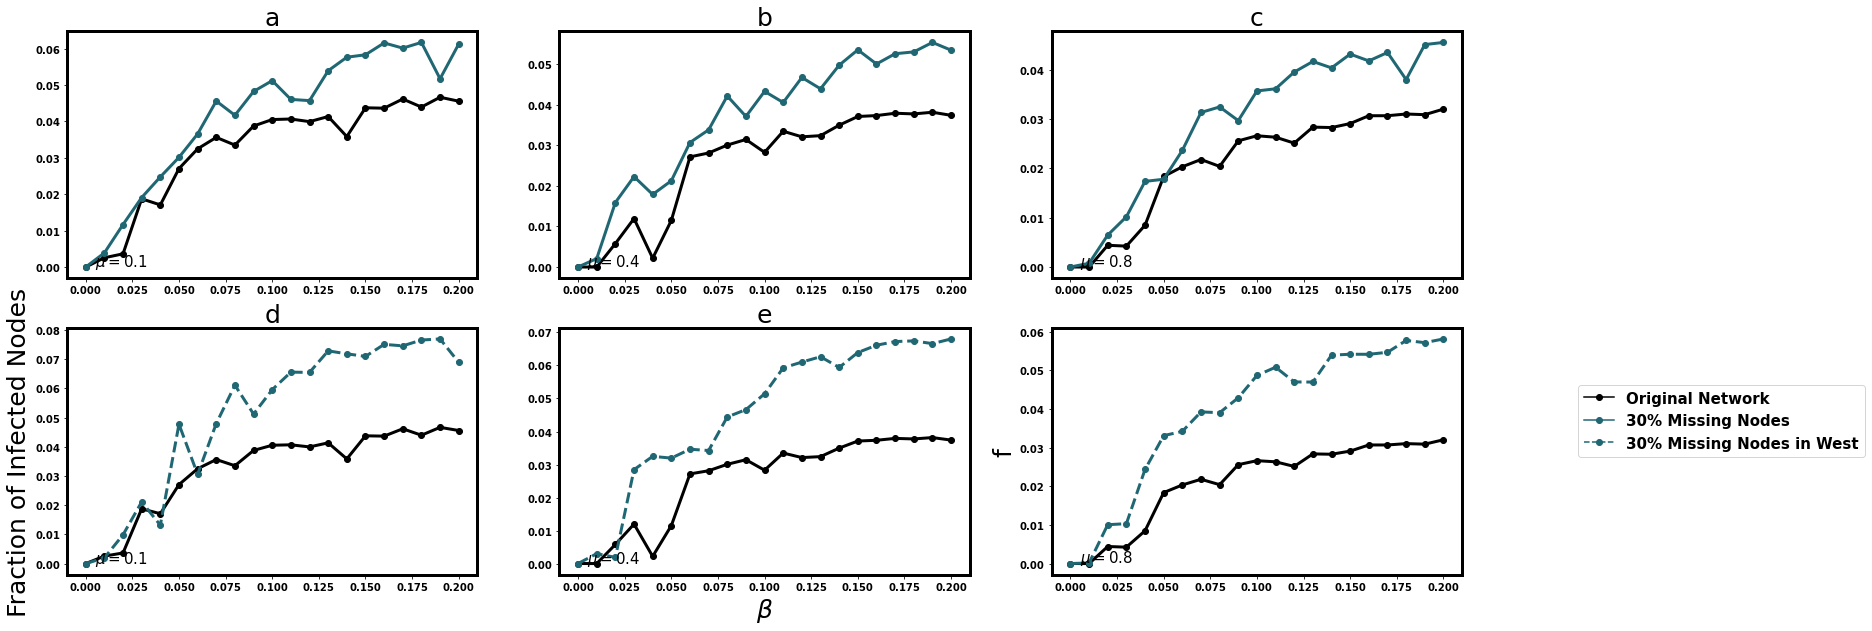

In [249]:
fig,axs=plt.subplots(2, 3, figsize=[25,10])

axs[0,0].plot(df['beta'],mean,marker='o', c='black',linewidth=3.0)
axs[0,0].plot(df_miss_30['beta'],mean_miss30,marker='o',c='#206774',linewidth=3.0)
#axs[0,0].set_xlim(0,0.05)
axs[0,0].text(0.005,0.0003,r'$\mu=0.1$',fontsize=15)
axs[0,1].plot(df_1['beta'],mean_1,marker='o', c='black',linewidth=3.0)
axs[0,1].plot(df_miss_30_1['beta'],mean_miss30_1,marker='o',c='#206774',linewidth=3.0)
#axs[0,1].set_xlim(0,0.05)
axs[0,1].text(0.005,0.0003,r'$\mu=0.4$',fontsize=15)
axs[0,2].plot(df_3['beta'],mean_3,marker='o', c='black',linewidth=3.0)
axs[0,2].plot(df_miss_30_3['beta'],mean_miss30_3,marker='o',c='#206774',linewidth=3.0)
#axs[0,2].set_xlim(0,0.05)
axs[0,2].text(0.005,0.0003,r'$\mu=0.8$',fontsize=15)


axs[1,0].plot(df['beta'],mean,marker='o', c='black',linewidth=3.0)
axs[1,0].plot(df_miss_30_w['beta'],mean_miss30_w,marker='o',c='#206774',linewidth=3.0,linestyle='--')
#axs[1,0].set_xlim(0,0.05)
axs[1,0].text(0.005,0.0003,r'$\mu=0.1$',fontsize=15)
axs[1,1].plot(df_1['beta'],mean_1,marker='o', c='black',linewidth=3.0)
axs[1,1].plot(df_miss_30_w_1['beta'],mean_miss30_w_1,marker='o',c='#206774',linewidth=3.0,linestyle='--')
#axs[1,1].set_xlim(0,0.05)
axs[1,1].text(0.005,0.0003,r'$\mu=0.4$',fontsize=15)
axs[1,2].plot(df_3['beta'],mean_3,marker='o', c='black',linewidth=3.0)
axs[1,2].plot(df_miss_30_w_3['beta'],mean_miss30_w_3,marker='o',c='#206774',linewidth=3.0,linestyle='--')
#axs[1,2].set_xlim(0,0.05)
axs[1,2].text(0.005,0.0003,r'$\mu=0.8$',fontsize=15)


axs[0,0].set_title('a',fontsize=25)
axs[0,1].set_title('b',fontsize=25)
axs[0,2].set_title('c',fontsize=25)
axs[1,0].set_title('d',fontsize=25)
axs[1,1].set_title('e',fontsize=25)
axs[1,2].set_ylabel('f',fontsize=25)

axs[1,0].set_ylabel('Fraction of Infected Nodes',fontsize=25)
axs[1,1].set_xlabel(r'$\beta$',fontsize=25)
#axs[0,0].set_xticklabels([])
#axs[0,1].set_xticklabels([])
#axs[1,0].set_xticklabels([])
#import matplotlib.patches as mpatches
import matplotlib.lines as mlines
c1 = mlines.Line2D([], [], color='black', marker='o',linestyle='-', label='Original Network')
c2 = mlines.Line2D([], [], color='#206774',marker='o' ,linestyle='-', label='30% Missing Nodes')
c3 = mlines.Line2D([], [], color='#206774',marker='o' ,linestyle='--', label='30% Missing Nodes in West')
plt.legend(handles=[c1,c2,c3],bbox_to_anchor=(2, 0.8),fontsize=15)
#bold the x and y axis thicks all together
plt.rc('font', weight='bold')
#plt.savefig('epidemic_misslink_entire_west_1.pdf')


In [250]:
G_unw_50_w=nx.read_gpickle("real_network/G_unw_w_50.gpickle")
G_unw_50=nx.read_gpickle("real_network/G_unw_entire_50.gpickle")


In [378]:
#epidemic threshold for weight scenario
beta_range1=np.arange(0, 0.21, 0.01).tolist()
mu1=0.4
df_unw_50_1, mean_unw50_1=epidemic_threshold_multirun(beta_range1,G_unw_50,IN_IN_risk_region,mu1)
#df_1, mean_1=epidemic_threshold_multirun(beta_range1,G_original,IN_IN_risk_region,mu1)
mu3=0.8
df_unw_50_3, mean_unw50_3=epidemic_threshold_multirun(beta_range1,G_unw_50,IN_IN_risk_region,mu3)
#df_3, mean_3=epidemic_threshold_multirun(beta_range1,G_original,IN_IN_risk_region,mu3)
mu=0.1
df_unw_50, mean_unw50=epidemic_threshold_multirun(beta_range1,G_unw_50,IN_IN_risk_region,mu)
#df, mean=epidemic_threshold_multirun(beta_range1,G_original,IN_IN_risk_region,mu)

In [353]:
beta_range1=np.arange(0, 0.21, 0.01).tolist()
#epidemic threshold for weight scenario
mu1=0.4
df_unw_50_w_1, mean_unw50_w_1=epidemic_threshold_multirun(beta_range1,G_unw_50_w,IN_IN_risk_region,mu1)
#df_1, mean_1=epidemic_threshold_multirun(beta_range1,G_original,IN_IN_risk_region,mu1)
mu3=0.8
df_unw_50_w_3, mean_unw50_w_3=epidemic_threshold_multirun(beta_range1,G_unw_50_w,IN_IN_risk_region,mu3)
#df_3, mean_3=epidemic_threshold_multirun(beta_range1,G_original,IN_IN_risk_region,mu3)
mu=0.1
df_unw_50_w, mean_unw50_w=epidemic_threshold_multirun(beta_range1,G_unw_50_w,IN_IN_risk_region,mu)

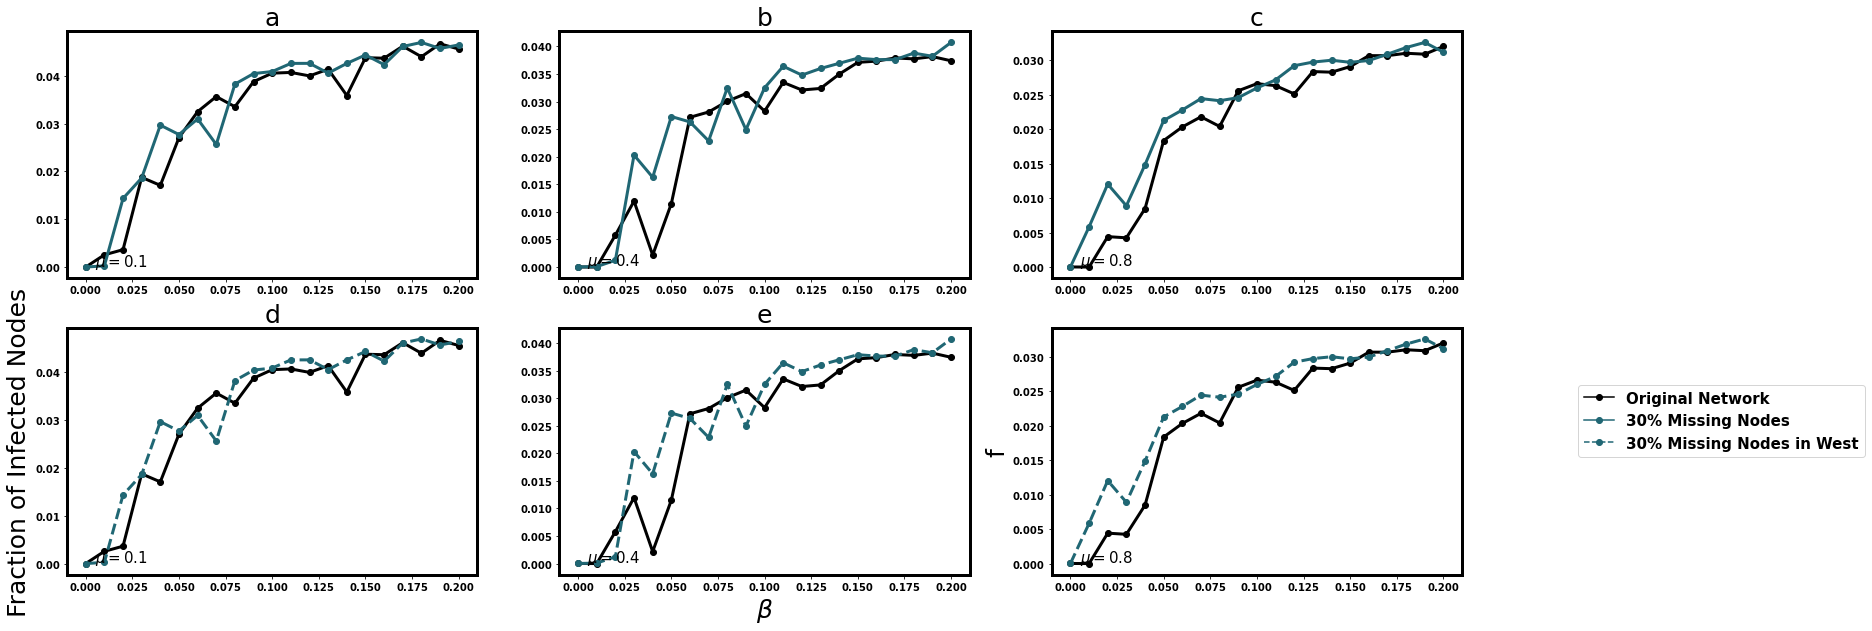

In [256]:
fig,axs=plt.subplots(2, 3, figsize=[25,10])

axs[0,0].plot(df['beta'],mean,marker='o', c='black',linewidth=3.0)
axs[0,0].plot(df_unw_50['beta'],mean_unw50,marker='o',c='#206774',linewidth=3.0)
#axs[0,0].set_xlim(0,0.05)
axs[0,0].text(0.005,0.0003,r'$\mu=0.1$',fontsize=15)
axs[0,1].plot(df_1['beta'],mean_1,marker='o', c='black',linewidth=3.0)
axs[0,1].plot(df_unw_50_1['beta'],mean_unw50_1,marker='o',c='#206774',linewidth=3.0)
#axs[0,1].set_xlim(0,0.05)
axs[0,1].text(0.005,0.0003,r'$\mu=0.4$',fontsize=15)
axs[0,2].plot(df_3['beta'],mean_3,marker='o', c='black',linewidth=3.0)
axs[0,2].plot(df_unw_50_3['beta'],mean_unw50_3,marker='o',c='#206774',linewidth=3.0)
#axs[0,2].set_xlim(0,0.05)
axs[0,2].text(0.005,0.0003,r'$\mu=0.8$',fontsize=15)


axs[1,0].plot(df['beta'],mean,marker='o', c='black',linewidth=3.0)
axs[1,0].plot(df_unw_50_w['beta'],mean_unw50,marker='o',c='#206774',linewidth=3.0,linestyle='--')
#axs[1,0].set_xlim(0,0.05)
axs[1,0].text(0.005,0.0003,r'$\mu=0.1$',fontsize=15)
axs[1,1].plot(df_1['beta'],mean_1,marker='o', c='black',linewidth=3.0)
axs[1,1].plot(df_unw_50_w_1['beta'],mean_unw50_1,marker='o',c='#206774',linewidth=3.0,linestyle='--')
#axs[1,1].set_xlim(0,0.05)
axs[1,1].text(0.005,0.0003,r'$\mu=0.4$',fontsize=15)
axs[1,2].plot(df_3['beta'],mean_3,marker='o', c='black',linewidth=3.0)
axs[1,2].plot(df_unw_50_w_3['beta'],mean_unw50_3,marker='o',c='#206774',linewidth=3.0,linestyle='--')
#axs[1,2].set_xlim(0,0.05)
axs[1,2].text(0.005,0.0003,r'$\mu=0.8$',fontsize=15)


axs[0,0].set_title('a',fontsize=25)
axs[0,1].set_title('b',fontsize=25)
axs[0,2].set_title('c',fontsize=25)
axs[1,0].set_title('d',fontsize=25)
axs[1,1].set_title('e',fontsize=25)
axs[1,2].set_ylabel('f',fontsize=25)

axs[1,0].set_ylabel('Fraction of Infected Nodes',fontsize=25)
axs[1,1].set_xlabel(r'$\beta$',fontsize=25)
#axs[0,0].set_xticklabels([])
#axs[0,1].set_xticklabels([])
#axs[1,0].set_xticklabels([])
#import matplotlib.patches as mpatches
import matplotlib.lines as mlines
c1 = mlines.Line2D([], [], color='black', marker='o',linestyle='-', label='Original Network')
c2 = mlines.Line2D([], [], color='#206774',marker='o' ,linestyle='-', label='30% Missing Nodes')
c3 = mlines.Line2D([], [], color='#206774',marker='o' ,linestyle='--', label='30% Missing Nodes in West')
plt.legend(handles=[c1,c2,c3],bbox_to_anchor=(2, 0.8),fontsize=15)
#bold the x and y axis thicks all together
plt.rc('font', weight='bold')
#plt.savefig('epidemic_misslink_entire_west_1.pdf')

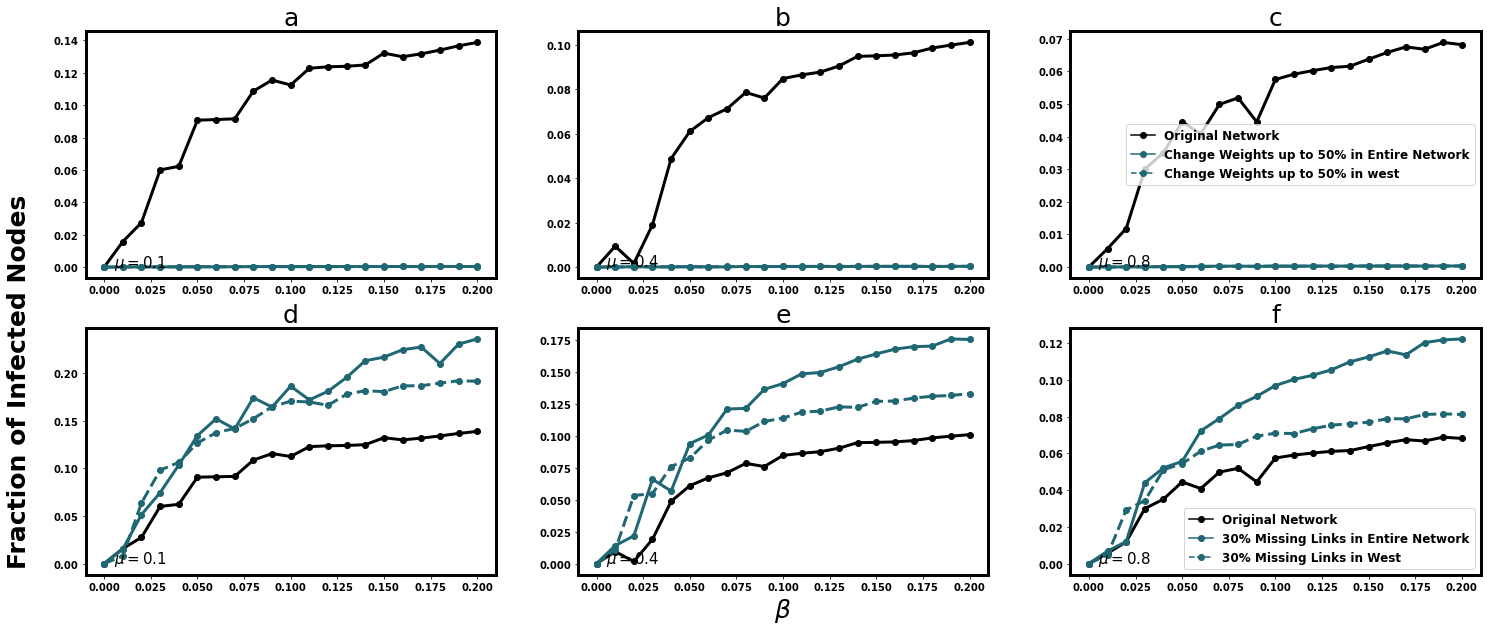

In [377]:
fig,axs=plt.subplots(2, 3, figsize=[25,10])

axs[0,0].plot(df['beta'],mean,marker='o', c='black',linewidth=3.0)
axs[0,0].plot(df_unw_50['beta'],mean_unw50,marker='o',c='#206774',linewidth=3.0)
axs[0,0].plot(df_unw_50_w['beta'],mean_unw50_w,marker='o',c='#206774',linewidth=3.0,linestyle='--')
#axs[0,0].set_xlim(0,0.05)
axs[0,0].text(0.005,0.00033,r'$\mu=0.1$',fontsize=15)
axs[0,1].plot(df_1['beta'],mean_1,marker='o', c='black',linewidth=3.0)
axs[0,1].plot(df_unw_50_1['beta'],mean_unw50_1,marker='o',c='#206774',linewidth=3.0)
axs[0,1].plot(df_unw_50_w_1['beta'],mean_unw50_w_1,marker='o',c='#206774',linewidth=3.0,linestyle='--')
#axs[0,1].set_xlim(0,0.05)
axs[0,1].text(0.005,0.0003,r'$\mu=0.4$',fontsize=15)
axs[0,2].plot(df_3['beta'],mean_3,marker='o', c='black',linewidth=3.0)
axs[0,2].plot(df_unw_50_3['beta'],mean_unw50_3,marker='o',c='#206774',linewidth=3.0)
axs[0,2].plot(df_unw_50_w_3['beta'],mean_unw50_w_3,marker='o',c='#206774',linewidth=3.0,linestyle='--')
#axs[0,2].set_xlim(0,0.05)
axs[0,2].text(0.005,0.00028,r'$\mu=0.8$',fontsize=15)


axs[1,0].plot(df['beta'],mean,marker='o', c='black',linewidth=3.0)
axs[1,0].plot(df_miss_30['beta'],mean_miss30,marker='o',c='#206774',linewidth=3.0)
axs[1,0].plot(df_miss_30_w['beta'],mean_miss30_w,marker='o',c='#206774',linewidth=3.0,linestyle='--')
#axs[1,0].set_xlim(0,0.05)
axs[1,0].text(0.005,0.0004,r'$\mu=0.1$',fontsize=15)
axs[1,1].plot(df_1['beta'],mean_1,marker='o', c='black',linewidth=3.0)
axs[1,1].plot(df_miss_30_1['beta'],mean_miss30_1,marker='o',c='#206774',linewidth=3.0)
axs[1,1].plot(df_miss_30_w_1['beta'],mean_miss30_w_1,marker='o',c='#206774',linewidth=3.0,linestyle='--')
#axs[1,1].set_xlim(0,0.05)
axs[1,1].text(0.005,0.00038,r'$\mu=0.4$',fontsize=15)
axs[1,2].plot(df_3['beta'],mean_3,marker='o', c='black',linewidth=3.0)
axs[1,2].plot(df_miss_30_3['beta'],mean_miss30_3,marker='o',c='#206774',linewidth=3.0)
axs[1,2].plot(df_miss_30_w_3['beta'],mean_miss30_w_3,marker='o',c='#206774',linewidth=3.0,linestyle='--')
#axs[1,2].set_xlim(0,0.05)
axs[1,2].text(0.005,0.00035,r'$\mu=0.8$',fontsize=15)



axs[0,0].set_title('a',fontsize=25)
axs[0,1].set_title('b',fontsize=25)
axs[0,2].set_title('c',fontsize=25)
axs[1,0].set_title('d',fontsize=25)
axs[1,1].set_title('e',fontsize=25)
axs[1,2].set_title('f',fontsize=25)

#axs[1,0].set_ylabel('Fraction of Infected Nodes',fontsize=25)
axs[1,1].set_xlabel(r'$\beta$',fontsize=25)

#import matplotlib.patches as mpatches
import matplotlib.lines as mlines
c1 = mlines.Line2D([], [], color='black', marker='o',linestyle='-', label='Original Network')
c2 = mlines.Line2D([], [], color='#206774',marker='o' ,linestyle='-', label='Change Weights up to 50% in Entire Network')
c3 = mlines.Line2D([], [], color='#206774',marker='o' ,linestyle='--', label='Change Weights up to 50% in west')
axs[0,2].legend(handles=[c1,c2,c3],fontsize=12)
c4 = mlines.Line2D([], [], color='black', marker='o',linestyle='-', label='Original Network')
c5 = mlines.Line2D([], [], color='#206774',marker='o' ,linestyle='-', label='30% Missing Links in Entire Network')
c6 = mlines.Line2D([], [], color='#206774',marker='o' ,linestyle='--', label='30% Missing Links in West')
axs[1,2].legend(handles=[c4,c5,c6],fontsize=12)
plt.text(-0.58, 0.00018,'Fraction of Infected Nodes',rotation=90,fontsize=25)
#bold the x and y axis thicks all together
plt.rc('font', weight='bold')
plt.savefig('epidemic_misslink_weights_entire_west_7step.pdf')

In [385]:
from scipy.interpolate import spline, make_interp_spline, BSpline
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter1d
beta_range1=np.arange(0, 0.21, 0.01).tolist()
x=beta_range1
#original network
y=np.array(list(mean))
y1=np.array(list(mean_1))
y2=np.array(list(mean_3))
y_new=gaussian_filter1d(y,sigma=1)
y1_new=gaussian_filter1d(y1,sigma=1)
y2_new=gaussian_filter1d(y2,sigma=1)

#change weights
#entire
y_w=np.array(list(mean_unw50))
y1_w=np.array(list(mean_unw50_1))
y2_w=np.array(list(mean_unw50_3))
y_w_new=gaussian_filter1d(y_w,sigma=2)
y1_w_new=gaussian_filter1d(y1_w,sigma=2)
y2_w_new=gaussian_filter1d(y2_w,sigma=2)
#west
y_w_w=np.array(list(mean_unw50_w))
y1_w_w=np.array(list(mean_unw50_w_1))
y2_w_w=np.array(list(mean_unw50_w_3))
y_w_w_new=gaussian_filter1d(y_w_w,sigma=1)
y1_w_w_new=gaussian_filter1d(y1_w_w,sigma=1)
y2_w_w_new=gaussian_filter1d(y2_w_w,sigma=1)


#missing links
#entire
y_miss=np.array(list(mean_miss30))
y1_miss=np.array(list(mean_miss30_1))
y2_miss=np.array(list(mean_miss30_3))
y_miss_new=gaussian_filter1d(y_miss,sigma=1)
y1_miss_new=gaussian_filter1d(y1_miss,sigma=1)
y2_miss_new=gaussian_filter1d(y2_miss,sigma=1)
#west
y_miss_w=np.array(list(mean_miss30_w))
y1_miss_w=np.array(list(mean_miss30_w_1))
y2_miss_w=np.array(list(mean_miss30_w_3))
y_miss_w_new=gaussian_filter1d(y_miss_w,sigma=1)
y1_miss_w_new=gaussian_filter1d(y1_miss_w,sigma=1)
y2_miss_w_new=gaussian_filter1d(y2_miss_w,sigma=1)


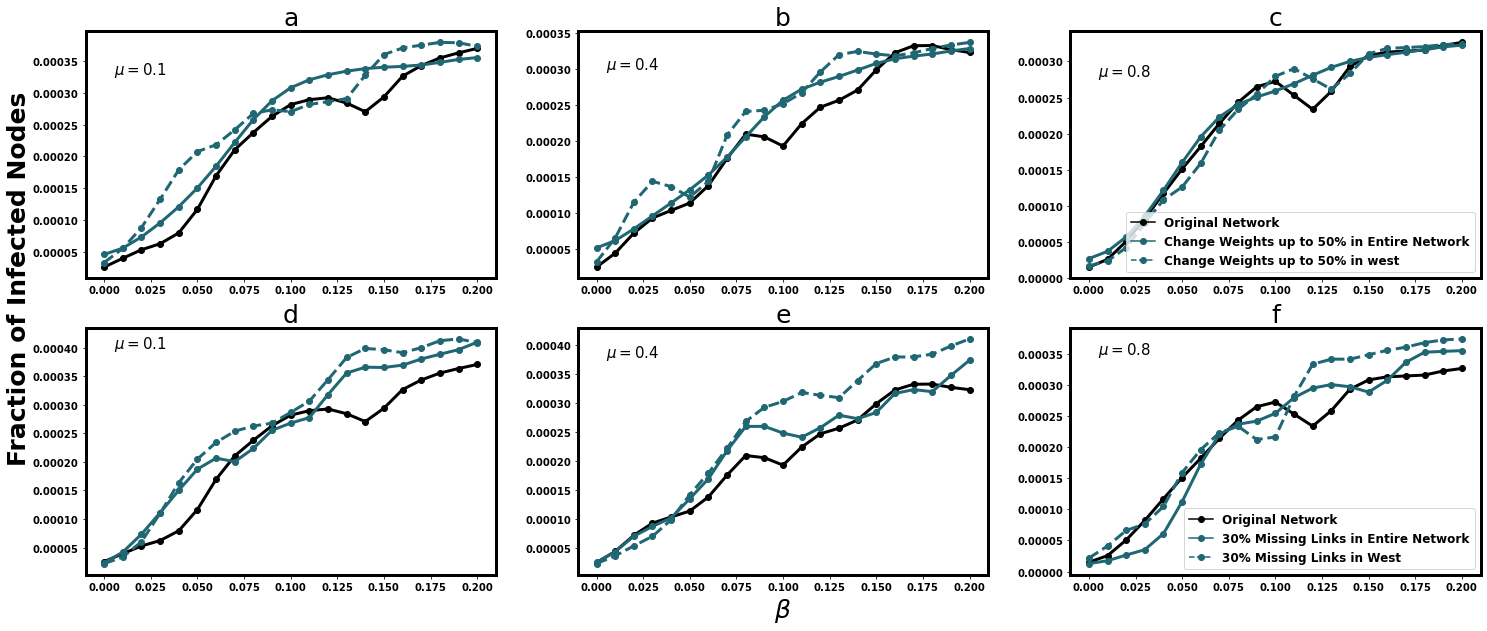

In [363]:


fig,axs=plt.subplots(2, 3, figsize=[25,10])

axs[0,0].plot(x,y_new,marker='o', c='black',linewidth=3.0)
axs[0,0].plot(x,y_w_new,marker='o',c='#206774',linewidth=3.0)
axs[0,0].plot(x,y_w_w_new,marker='o',c='#206774',linewidth=3.0,linestyle='--')
#axs[0,0].set_xlim(0,0.05)
axs[0,0].text(0.005,0.00033,r'$\mu=0.1$',fontsize=15)
axs[0,1].plot(x,y1_new,marker='o', c='black',linewidth=3.0)
axs[0,1].plot(x,y1_w_new,marker='o',c='#206774',linewidth=3.0)
axs[0,1].plot(x,y1_w_w_new,marker='o',c='#206774',linewidth=3.0,linestyle='--')
#axs[0,1].set_xlim(0,0.05)
axs[0,1].text(0.005,0.0003,r'$\mu=0.4$',fontsize=15)
axs[0,2].plot(x,y2_new,marker='o', c='black',linewidth=3.0)
axs[0,2].plot(x,y2_w_new,marker='o',c='#206774',linewidth=3.0)
axs[0,2].plot(x,y2_w_w_new,marker='o',c='#206774',linewidth=3.0,linestyle='--')
#axs[0,2].set_xlim(0,0.05)
axs[0,2].text(0.005,0.00028,r'$\mu=0.8$',fontsize=15)


axs[1,0].plot(x,y_new,marker='o', c='black',linewidth=3.0)
axs[1,0].plot(x,y_miss_new,marker='o',c='#206774',linewidth=3.0)
axs[1,0].plot(x,y_miss_w_new,marker='o',c='#206774',linewidth=3.0,linestyle='--')
#axs[1,0].set_xlim(0,0.05)
axs[1,0].text(0.005,0.0004,r'$\mu=0.1$',fontsize=15)
axs[1,1].plot(x,y1_new,marker='o', c='black',linewidth=3.0)
axs[1,1].plot(x,y1_miss_new,marker='o',c='#206774',linewidth=3.0)
axs[1,1].plot(x,y1_miss_w_new,marker='o',c='#206774',linewidth=3.0,linestyle='--')
#axs[1,1].set_xlim(0,0.05)
axs[1,1].text(0.005,0.00038,r'$\mu=0.4$',fontsize=15)
axs[1,2].plot(x,y2_new,marker='o', c='black',linewidth=3.0)
axs[1,2].plot(x,y2_miss_new,marker='o',c='#206774',linewidth=3.0)
axs[1,2].plot(x,y2_miss_w_new,marker='o',c='#206774',linewidth=3.0,linestyle='--')
#axs[1,2].set_xlim(0,0.05)
axs[1,2].text(0.005,0.00035,r'$\mu=0.8$',fontsize=15)



axs[0,0].set_title('a',fontsize=25)
axs[0,1].set_title('b',fontsize=25)
axs[0,2].set_title('c',fontsize=25)
axs[1,0].set_title('d',fontsize=25)
axs[1,1].set_title('e',fontsize=25)
axs[1,2].set_title('f',fontsize=25)

#axs[1,0].set_ylabel('Fraction of Infected Nodes',fontsize=25)
axs[1,1].set_xlabel(r'$\beta$',fontsize=25)

#import matplotlib.patches as mpatches
import matplotlib.lines as mlines
c1 = mlines.Line2D([], [], color='black', marker='o',linestyle='-', label='Original Network')
c2 = mlines.Line2D([], [], color='#206774',marker='o' ,linestyle='-', label='Change Weights up to 50% in Entire Network')
c3 = mlines.Line2D([], [], color='#206774',marker='o' ,linestyle='--', label='Change Weights up to 50% in west')
axs[0,2].legend(handles=[c1,c2,c3],fontsize=12)
c4 = mlines.Line2D([], [], color='black', marker='o',linestyle='-', label='Original Network')
c5 = mlines.Line2D([], [], color='#206774',marker='o' ,linestyle='-', label='30% Missing Links in Entire Network')
c6 = mlines.Line2D([], [], color='#206774',marker='o' ,linestyle='--', label='30% Missing Links in West')
axs[1,2].legend(handles=[c4,c5,c6],fontsize=12)
plt.text(-0.58, 0.00018,'Fraction of Infected Nodes',rotation=90,fontsize=25)
#bold the x and y axis thicks all together
plt.rc('font', weight='bold')
plt.savefig('epidemic_misslink_weights_entire_west_qussifit_2step.pdf')

In [ ]:
import pickle
with open ('real_network/Epidemic_Threshold/mean_miss_5tep_0.8', 'rb') as fp:
    mean_miss30_3=pickle.load(fp)
with open ('real_network/Epidemic_Threshold/mean_miss_5tep_0.1', 'rb') as fp:
    mean_miss30=pickle.load(fp)
with open ('real_network/Epidemic_Threshold/mean_miss_5tep_0.4', 'rb') as fp:
    mean_miss30_1=pickle.load(fp)
    
with open ('real_network/Epidemic_Threshold/mean_miss_w_5tep_0.8', 'rb') as fp:
    mean_miss30_w_3=pickle.load(fp)
    
with open ('real_network/Epidemic_Threshold/mean_miss_w_5tep_0.1', 'rb') as fp:
    mean_miss30_w=pickle.load(fp)    
with open ('real_network/Epidemic_Threshold/mean_miss_w_5tep_0.4', 'rb') as fp:
    mean_miss30_w_1=pickle.load(fp)
    
with open ('real_network/Epidemic_Threshold/mean_unw_5tep_0.8', 'rb') as fp:
    mean_unw50_3=pickle.load(fp)
with open ('real_network/Epidemic_Threshold/mean_unw_5tep_0.1', 'rb') as fp:
    mean_unw50=pickle.load(fp)
with open ('real_network/Epidemic_Threshold/mean_unw_5tep_0.4', 'rb') as fp:
    mean_unw50_1=pickle.load(fp)   
    
with open ('real_network/Epidemic_Threshold/mean_unw_w_5tep_0.8', 'rb') as fp:
    mean_unw50_w_3=pickle.load(fp)
with open ('real_network/Epidemic_Threshold/mean_unw_w_5tep_0.1', 'rb') as fp:
    mean_unw50_w=pickle.load(fp)
with open ('real_network/Epidemic_Threshold/mean_unw_w_5tep_0.4', 'rb') as fp:
    mean_unw50_w_1=pickle.load(fp)

In [395]:
with open ('real_network/Epidemic_Threshold/mean_miss_5tep_0.4', 'rb') as fp:
    mean_miss30_1=pickle.load(fp)

In [407]:
from scipy.interpolate import spline, make_interp_spline, BSpline
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter1d
beta_range1=np.arange(0, 0.21, 0.01).tolist()
x=beta_range1
#original network
y=np.array(list(mean))
y1=np.array(list(mean_1))
y2=np.array(list(mean_3))
y_new=gaussian_filter1d(y,sigma=1)
y1_new=gaussian_filter1d(y1,sigma=1)
y2_new=gaussian_filter1d(y2,sigma=1)


#missing links
#entire
y_miss=np.array(list(mean_miss30))
y1_miss=np.array(list(mean_miss30_1))
y2_miss=np.array(list(mean_miss30_3))
y_miss_new=gaussian_filter1d(y_miss,sigma=1)
y1_miss_new=gaussian_filter1d(y1_miss,sigma=1)
y2_miss_new=gaussian_filter1d(y2_miss,sigma=1)
#west
y_miss_w=np.array(list(mean_miss30_w))
y1_miss_w=np.array(list(mean_miss30_w_1))
y2_miss_w=np.array(list(mean_miss30_w_3))
y_miss_w_new=gaussian_filter1d(y_miss_w,sigma=1)
y1_miss_w_new=gaussian_filter1d(y1_miss_w,sigma=1)
y2_miss_w_new=gaussian_filter1d(y2_miss_w,sigma=1)

In [408]:
y_new[0]=0.000014
y1_new[0]=0.000014
y2_new[0]=0.000014
y_miss_new[0]=0.000014
y1_miss_new[0]=0.000014
y2_miss_new[0]=0.000014
y_miss_w_new[0]=0.000014
y1_miss_w_new[0]=0.000014
y2_miss_w_new[0]=0.000014

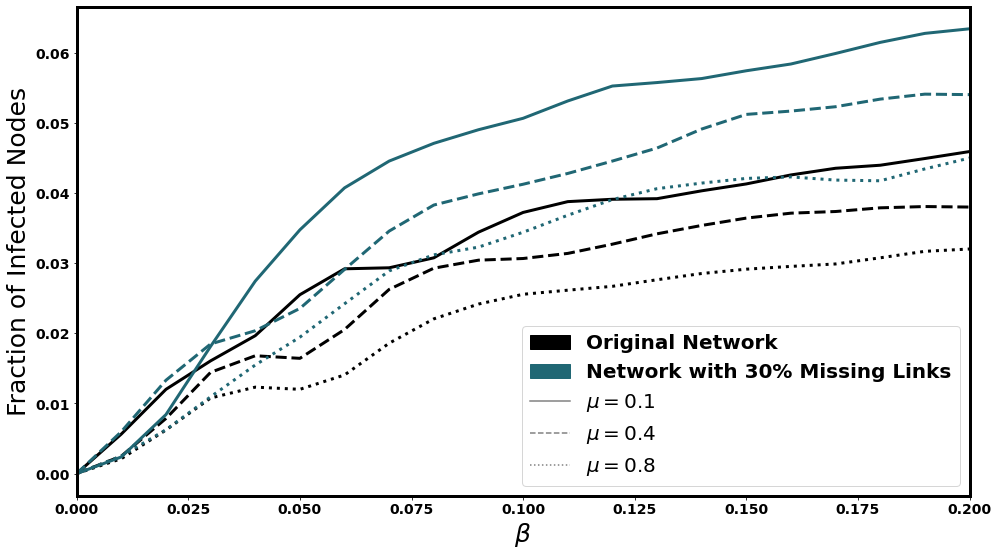

In [410]:
fig, ax = plt.subplots(1,1,figsize=(16,9))

plt.plot(x,y_new,c='black',linewidth=3.0)
plt.plot(x,y1_new,c='black',linestyle='--',linewidth=3.0)
plt.plot(x,y2_new,c='black',linestyle='dotted',linewidth=3.0)

plt.plot(x,y_miss_new,c='#206774',linewidth=3.0)
plt.plot(x,y1_miss_new,c='#206774',linestyle='--',linewidth=3.0)
plt.plot(x,y2_miss_new,c='#206774',linestyle='dotted',linewidth=3.0)
#ax.annotate('', (0.025, 0), xytext=(0.025+0.05, 0+0.02), 
 #   arrowprops=dict(facecolor='red', shrink=1))
fontsize = 14

for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
    tick.label1.set_fontweight('bold')
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
    tick.label1.set_fontweight('bold')
plt.rc('axes', linewidth=3) 
plt.xlabel(r'$\beta$',fontsize=25)
plt.ylabel('Fraction of Infected Nodes',fontsize=25)
plt.xlim(0,0.2)

import matplotlib.patches as mpatches
import matplotlib.lines as mlines
c1=mpatches.Patch(color='black', label='Original Network')
c2=mpatches.Patch(color='#206774', label='Network with 30% Missing Links')
c3= mlines.Line2D([], [], color='gray',linestyle='-', label=r'$\mu=0.1$')
c4= mlines.Line2D([], [], color='gray',linestyle='--', label=r'$\mu=0.4$')
c5 = mlines.Line2D([], [], color='gray', linestyle='dotted', label=r'$\mu=0.8$')
plt.legend(handles=[c1,c2,c3,c4,c5],fontsize=20)
plt.savefig('epidemic_threshold_miss_allmus_5step.pdf')

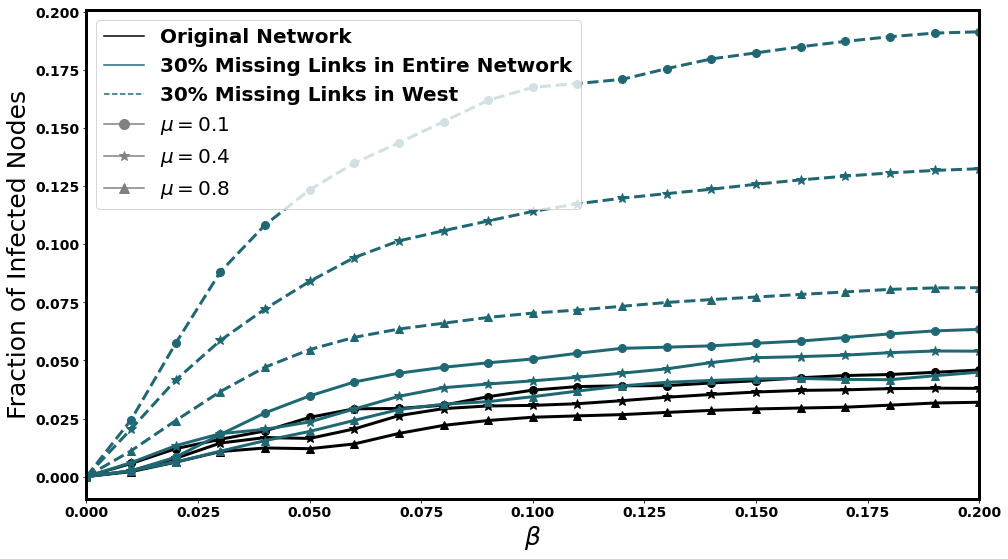

In [411]:
fig, ax = plt.subplots(1,1,figsize=(16,9))

plt.plot(x,y_new,c='black',marker='o',markersize=8,linewidth=3.0)
plt.plot(x,y1_new,c='black',marker='*',markersize=10,linewidth=3.0)
plt.plot(x,y2_new,c='black',marker='^',markersize=8,linewidth=3.0)

plt.plot(x,y_miss_new,c='#206774',marker='o',markersize=8,linewidth=3.0)
plt.plot(x,y1_miss_new,c='#206774',marker='*',markersize=10,linewidth=3.0)
plt.plot(x,y2_miss_new,c='#206774',marker='^',markersize=8,linewidth=3.0)

plt.plot(x,y_miss_w_new,c='#206774',marker='o',markersize=8,linestyle='--',linewidth=3.0)
plt.plot(x,y1_miss_w_new,c='#206774',marker='*',markersize=10,linestyle='--',linewidth=3.0)
plt.plot(x,y2_miss_w_new,c='#206774',marker='^',markersize=8,linestyle='--',linewidth=3.0)
#ax.annotate('', (0.025, 0), xytext=(0.025+0.05, 0+0.02), 
 #   arrowprops=dict(facecolor='red', shrink=1))
fontsize = 14

for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
    tick.label1.set_fontweight('bold')
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
    tick.label1.set_fontweight('bold')
plt.rc('axes', linewidth=3) 
plt.xlabel(r'$\beta$',fontsize=25)
plt.ylabel('Fraction of Infected Nodes',fontsize=25)
plt.xlim(0,0.2)

import matplotlib.patches as mpatches
import matplotlib.lines as mlines
c1=mlines.Line2D([],[],color='black', linestyle='-',label='Original Network')
c2=mlines.Line2D([],[],color='#206774',linestyle='-', label='30% Missing Links in Entire Network')
c6=mlines.Line2D([],[],color='#206774',linestyle='--', label='30% Missing Links in West')
c3= mlines.Line2D([], [], color='gray',marker='o',markersize=10, label=r'$\mu=0.1$')
c4= mlines.Line2D([], [], color='gray',marker='*',markersize=10, label=r'$\mu=0.4$')
c5 = mlines.Line2D([], [], color='gray', marker='^',markersize=10, label=r'$\mu=0.8$')
plt.legend(handles=[c1,c2,c6,c3,c4,c5],fontsize=20)
plt.savefig('epidemic_threshold_miss_entire_west_allmus_5step.pdf')

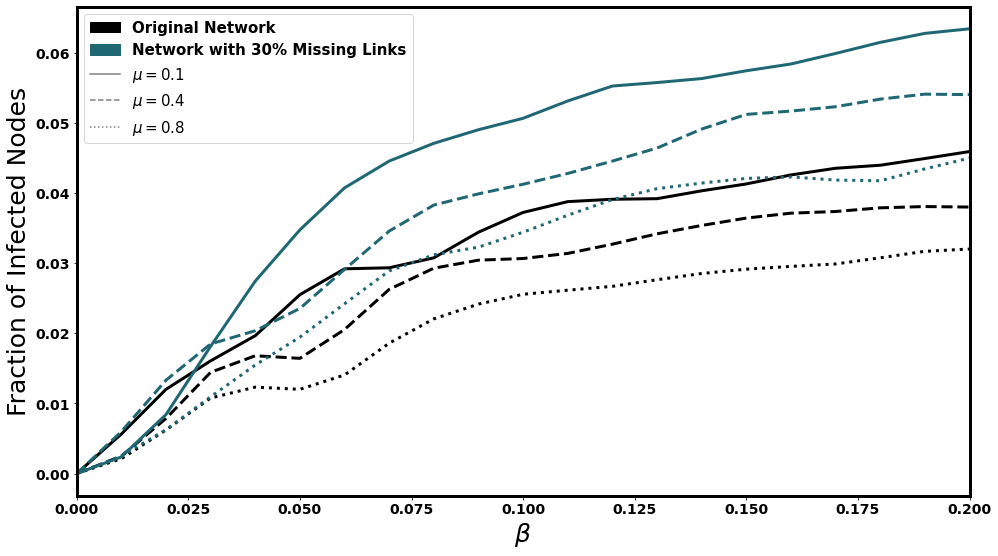

In [412]:
fig, ax = plt.subplots(1,1,figsize=(16,9))

plt.plot(x,y_new,c='black',linewidth=3.0)
plt.plot(x,y1_new,c='black',linestyle='--',linewidth=3.0)
plt.plot(x,y2_new,c='black',linestyle='dotted',linewidth=3.0)

plt.plot(x,y_miss_new,c='#206774',linewidth=3.0)
plt.plot(x,y1_miss_new,c='#206774',linestyle='--',linewidth=3.0)
plt.plot(x,y2_miss_new,c='#206774',linestyle='dotted',linewidth=3.0)
#ax.annotate('', (0.025, 0), xytext=(0.025+0.05, 0+0.02), 
 #   arrowprops=dict(facecolor='red', shrink=1))
fontsize = 14

for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
    tick.label1.set_fontweight('bold')
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
    tick.label1.set_fontweight('bold')
plt.rc('axes', linewidth=3) 
plt.xlabel(r'$\beta$',fontsize=25)
plt.ylabel('Fraction of Infected Nodes',fontsize=25)
plt.xlim(0,0.2)

import matplotlib.patches as mpatches
import matplotlib.lines as mlines
c1=mpatches.Patch(color='black', label='Original Network')
c2=mpatches.Patch(color='#206774', label='Network with 30% Missing Links')
c3= mlines.Line2D([], [], color='gray',linestyle='-', label=r'$\mu=0.1$')
c4= mlines.Line2D([], [], color='gray',linestyle='--', label=r'$\mu=0.4$')
c5 = mlines.Line2D([], [], color='gray', linestyle='dotted', label=r'$\mu=0.8$')
plt.legend(handles=[c1,c2,c3,c4,c5],fontsize=15)
plt.savefig('epidemic_threshold_miss_entire_allmus_5step.pdf')

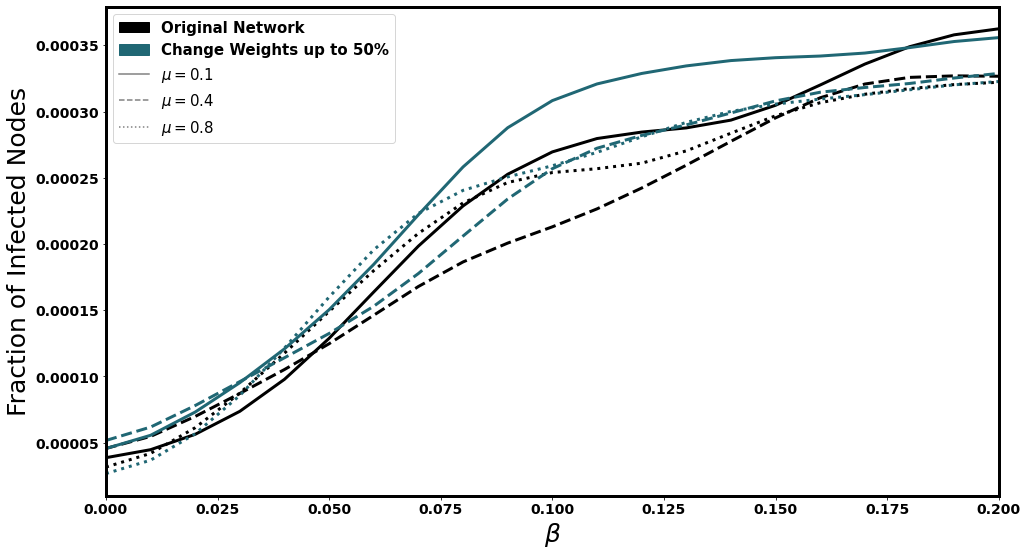

In [371]:
fig, ax = plt.subplots(1,1,figsize=(16,9))

plt.plot(x,y_new,c='black',linewidth=3.0)
plt.plot(x,y1_new,c='black',linestyle='--',linewidth=3.0)
plt.plot(x,y2_new,c='black',linestyle='dotted',linewidth=3.0)

plt.plot(x,y_w_new,c='#206774',linewidth=3.0)
plt.plot(x,y1_w_new,c='#206774',linestyle='--',linewidth=3.0)
plt.plot(x,y2_w_new,c='#206774',linestyle='dotted',linewidth=3.0)
#ax.annotate('', (0.025, 0), xytext=(0.025+0.05, 0+0.02), 
 #   arrowprops=dict(facecolor='red', shrink=1))
fontsize = 14

for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
    tick.label1.set_fontweight('bold')
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
    tick.label1.set_fontweight('bold')
plt.rc('axes', linewidth=3) 
plt.xlabel(r'$\beta$',fontsize=25)
plt.ylabel('Fraction of Infected Nodes',fontsize=25)
plt.xlim(0,0.2)

import matplotlib.patches as mpatches
import matplotlib.lines as mlines
c1=mpatches.Patch(color='black', label='Original Network')
c2=mpatches.Patch(color='#206774', label='Change Weights up to 50%')
c3= mlines.Line2D([], [], color='gray',linestyle='-', label=r'$\mu=0.1$')
c4= mlines.Line2D([], [], color='gray',linestyle='--', label=r'$\mu=0.4$')
c5 = mlines.Line2D([], [], color='gray', linestyle='dotted', label=r'$\mu=0.8$')
plt.legend(handles=[c1,c2,c3,c4,c5],fontsize=15)
plt.savefig('epidemic_threshold_weight_entire_allmus_2step.pdf')

In [438]:
import pickle
with open ('real_network/Epidemic_Threshold/I_MN_5step_beforeIn_0.8', 'rb') as fp:
    I_MN3=pickle.load(fp)
with open ('real_network/Epidemic_Threshold/I_MN_w_0.8', 'rb') as fp:
    I_MN_w3=pickle.load(fp)
with open ('real_network/Epidemic_Threshold/I_MN_5step_beforeIn_0.1', 'rb') as fp:
    I_MN=pickle.load(fp)
with open ('real_network/Epidemic_Threshold/I_MN_w_0.1', 'rb') as fp:
    I_MN_w=pickle.load(fp)
with open ('real_network/Epidemic_Threshold/I_MN_5step_beforeIn_0.4', 'rb') as fp:
    I_MN1=pickle.load(fp)
with open ('real_network/Epidemic_Threshold/I_MN_w_0.4', 'rb') as fp:
    I_MN_w1=pickle.load(fp)

In [436]:
I_MN1.append((0.2,I_MN1[-1][1]))
I_MN.append((0.2,I_MN[-1][1]))
I_MN3.append((0.2,I_MN3[-1][1]))

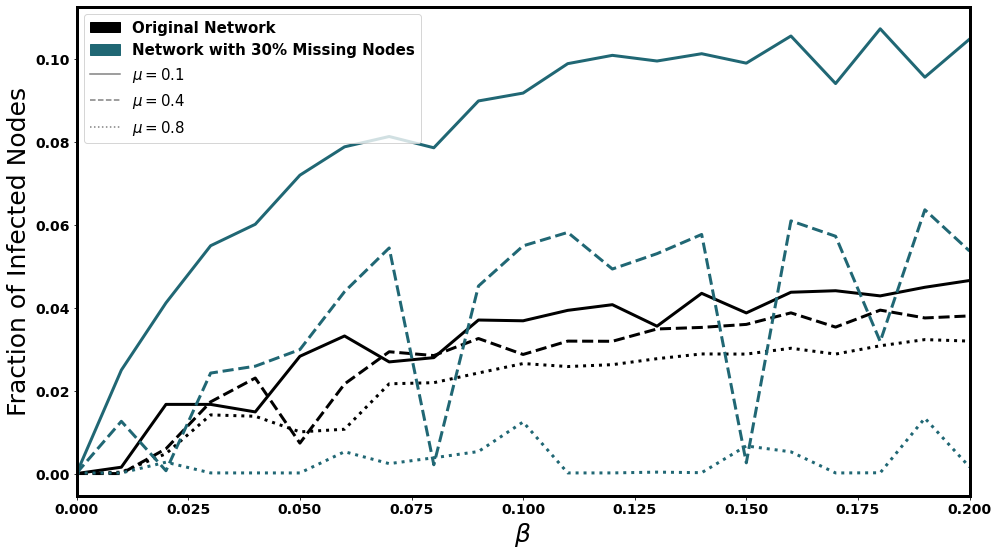

In [439]:
beta_range1=np.arange(0, 0.21, 0.01).tolist()
x=beta_range1
fig, ax = plt.subplots(1,1,figsize=(16,9))

plt.plot(x,mean,c='black',linewidth=3.0)
plt.plot(x,mean_1,c='black',linestyle='--',linewidth=3.0)
plt.plot(x,mean_3,c='black',linestyle='dotted',linewidth=3.0)

plt.plot(x,[i[1] for i in I_MN],c='#206774',linewidth=3.0)
plt.plot(x,[i[1] for i in I_MN1],c='#206774',linestyle='--',linewidth=3.0)
plt.plot(x,[i[1] for i in I_MN3],c='#206774',linestyle='dotted',linewidth=3.0)
#ax.annotate('', (0.025, 0), xytext=(0.025+0.05, 0+0.02), 
 #   arrowprops=dict(facecolor='red', shrink=1))
fontsize = 14

for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
    tick.label1.set_fontweight('bold')
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
    tick.label1.set_fontweight('bold')
plt.rc('axes', linewidth=3) 
plt.xlabel(r'$\beta$',fontsize=25)
plt.ylabel('Fraction of Infected Nodes',fontsize=25)
plt.xlim(0,0.2)

import matplotlib.patches as mpatches
import matplotlib.lines as mlines
c1=mpatches.Patch(color='black', label='Original Network')
c2=mpatches.Patch(color='#206774', label='Network with 30% Missing Nodes')
c3= mlines.Line2D([], [], color='gray',linestyle='-', label=r'$\mu=0.1$')
c4= mlines.Line2D([], [], color='gray',linestyle='--', label=r'$\mu=0.4$')
c5 = mlines.Line2D([], [], color='gray', linestyle='dotted', label=r'$\mu=0.8$')
plt.legend(handles=[c1,c2,c3,c4,c5],fontsize=15)
#plt.savefig('epidemic_threshold_MN_entire_allmus_5step.pdf')